In [59]:
!pip install tensorflow
!pip install matplotlib 
!pip install numpy scikit-learn pandas opencv-python seaborn shap


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Using cached shap-0.50.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.62.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.8 kB)
  Using cached cloudpickle-3.1.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached llvmlite-0.45.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (4.8 kB)
Using cached shap-0.50.0-cp312-cp312-macosx_11_0_arm64.whl (555 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached numba-0.62.1-cp312-cp312-macosx_11_0_arm64.whl (2.7 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached cloudpickle-3.1.2-py3-none-any.whl (22 kB)
Using cached llvmlite-0.45.1-cp312-cp312-macosx_11_

In [60]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import cv2
import os
import random
import seaborn as sns
import shap

/Users/leilatawfik/Desktop/FALL 2025/ENGG680_ML_Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
random.seed(42)

In [ ]:
#load images and do some preprocessing

#size for all images
image_resize = (128, 128)

#load and save the images 
def process_and_save(input_path, output_path):
    """
    Load an image, convert to grayscale, resize, and save.
    """
    img = cv2.imread(input_path)

    #for missing images 
    if img is None:
        print("Could not load:", input_path)
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #covert to grayscale
    img = cv2.resize(img, image_resize) #resize
    cv2.imwrite(output_path, img) #save 


#save output path to a folder
def process_folder(input_dir, output_dir):
    """
    Process every image in an input folder and save to output.
    """
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        in_path = os.path.join(input_dir, filename)
        out_path = os.path.join(output_dir, filename)

        if os.path.isfile(in_path):
            process_and_save(in_path, out_path)

#folders for eyes to save the datasets
eye_out_open = "Processed_Datasets/eyes/open_eye"
eye_out_closed = "Processed_Datasets/eyes/closed_eye"

#folders containing raw data for eyes
eye_sources_open = ["Raw_Data/Open_Eyes"]
eye_sources_closed = ["Raw_Data/Closed_Eyes"]

#process open eys 
for fldr in eye_sources_open:
    process_folder(fldr, eye_out_open)

# PROCESS CLOSED EYES
for fldr in eye_sources_closed:
    process_folder(fldr, eye_out_closed)

#folders for mouths to save the datasets
mouth_out_yawn = "Processed_Datasets/mouth/yawn"
mouth_out_noyawn  = "Processed_Datasets/mouth/no_yawn"

#folders containing raw data for mouths
mouth_sources_yawn = ["Raw_Data/Yawn"]
mouth_sources_noyawn = ["Raw_Data/No_Yawn"]


# PROCESS YAWN MOUTHS
for fldr in mouth_sources_yawn:
    process_folder(fldr, mouth_out_yawn)

# PROCESS NO-YAWN MOUTHS
for fldr in mouth_sources_noyawn:
    process_folder(fldr, mouth_out_noyawn)


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve

**EYE CNN MODEL**

In [6]:
#loading the processed datasets and preparing them for model training

def load_eye_dataset():
    X = []
    y = []

    # 0 = open, 1 = closed
    base_paths = {0: "Processed_Datasets/eyes/open_eye",
                  1: "Processed_Datasets/eyes/closed_eye"}

    for label, folder in base_paths.items():
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None: #handles missing data
                continue

            img = img.astype("float32") / 255.0
            img = np.expand_dims(img, axis=-1) #Axis is 1 for grayscale

            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)

X_eye, y_eye = load_eye_dataset()



In [45]:
#train test split
X_eye_train, X_eye_test, y_eye_train, y_eye_test = train_test_split(
    X_eye, y_eye,
    test_size=0.2, #20% test size
    stratify=y_eye, #equal class distribution
    random_state=42 #for reproducibility
)

#model architecture for eye state classification
def build_eye_cnn():
    model = models.Sequential([

        # Input shape: 128x128 grayscale
        layers.Input(shape=(128, 128, 1)),

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),     # Prevent overfitting
        layers.Dense(1, activation='sigmoid') #output layer
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

eye_model = build_eye_cnn()

history_eye = eye_model.fit(
    X_eye_train, y_eye_train,
    validation_data=(X_eye_test, y_eye_test),
    epochs=5,
    batch_size=32)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.4922 - loss: 0.7587 - val_accuracy: 0.8062 - val_loss: 0.6798
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.6531 - loss: 0.6336 - val_accuracy: 0.7625 - val_loss: 0.5515
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.7953 - loss: 0.4477 - val_accuracy: 0.8375 - val_loss: 0.3428
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - accuracy: 0.9297 - loss: 0.2402 - val_accuracy: 0.9750 - val_loss: 0.1046
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.9844 - loss: 0.0724 - val_accuracy: 0.9937 - val_loss: 0.0284


In [46]:
#metrics for test data
y_prob_eye = eye_model.predict(X_eye_test).ravel()

# Convert probability → class prediction (threshold = 0.5)
y_pred_eye = (y_prob_eye >= 0.5).astype(int)

acc = accuracy_score(y_eye_test, y_pred_eye)
rec = recall_score(y_eye_test, y_pred_eye, zero_division=0)
f1 = f1_score(y_eye_test, y_pred_eye, zero_division=0)
roc_auc = roc_auc_score(y_eye_test, y_prob_eye)
pr_auc = average_precision_score(y_eye_test, y_prob_eye)

# FNR = FN / (FN + TP)
tn, fp, fn, tp = confusion_matrix(y_eye_test, y_pred_eye).ravel()
fnr = fn / (fn + tp)

# print test metrics 
print("\nTest Metrics:")
print(f"Accuracy : {acc:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC-AUC  : {roc_auc:.3f}")
print(f"PR_AUC   : {pr_auc:.3f}")
print(f"FNR      : {fnr:.3f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

Test Metrics:
Accuracy : 0.994
Recall   : 1.000
F1-score : 0.994
ROC-AUC  : 1.000
PR_AUC   : 1.000
FNR      : 0.000


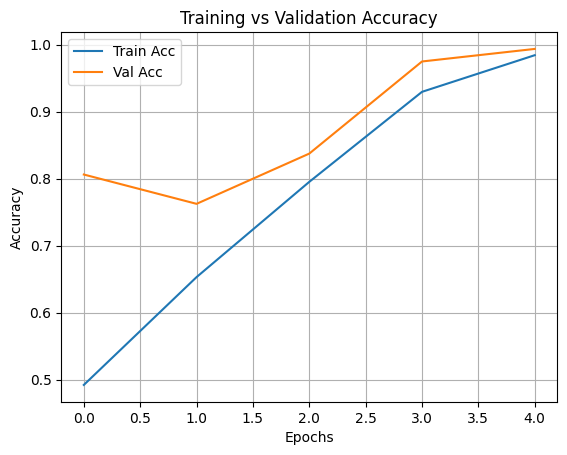

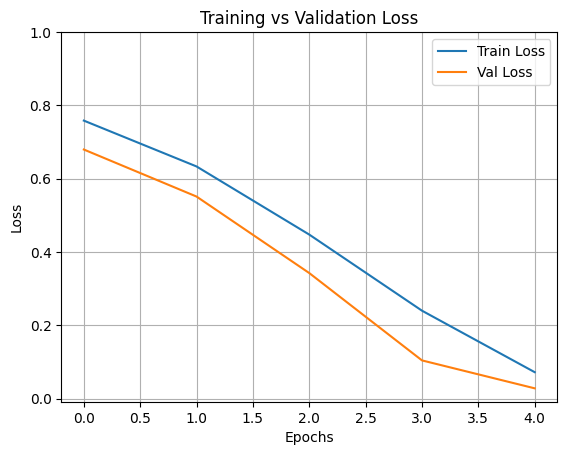

In [47]:
plt.plot(history_eye.history["accuracy"], label="Train Acc")
plt.plot(history_eye.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid()
plt.legend()
plt.show()

plt.plot(history_eye.history["loss"], label="Train Loss")
plt.plot(history_eye.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid()
plt.legend()
plt.ylim(top=1.0)
plt.show()

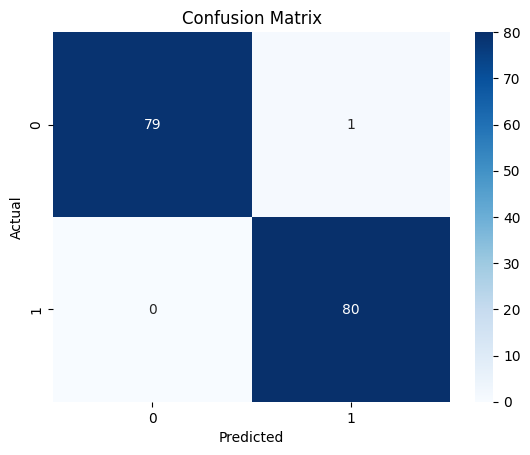

In [48]:
#confusion matrix heat map 

cm_eye = confusion_matrix(y_eye_test, y_pred_eye)
sns.heatmap(cm_eye, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Misclassified samples: 1


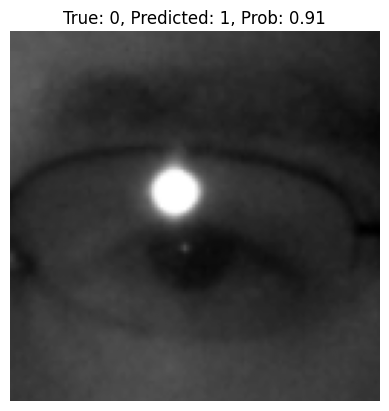

In [57]:
#dispalying mispredicted images

mis_idx = np.where(y_pred_eye != y_eye_test)[0]
print("Misclassified samples:", len(mis_idx))

#loop through wrongly labelled images to show all of them
for i in mis_idx:   
    plt.imshow(X_eye_test[i].squeeze(), cmap='gray')
    plt.title(f"True: {y_eye_test[i]}, Predicted: {y_pred_eye[i]}, Prob: {y_prob_eye[i]:.2f}")
    plt.axis('off')
    plt.show()

/Users/leilatawfik/Desktop/FALL 2025/ENGG680_ML_Project/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_77
Received: inputs=['Tensor(shape=(10, 128, 128, 1))']
  warnings.warn(msg)
/Users/leilatawfik/Desktop/FALL 2025/ENGG680_ML_Project/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_77
Received: inputs=['Tensor(shape=(50, 128, 128, 1))']
  warnings.warn(msg)


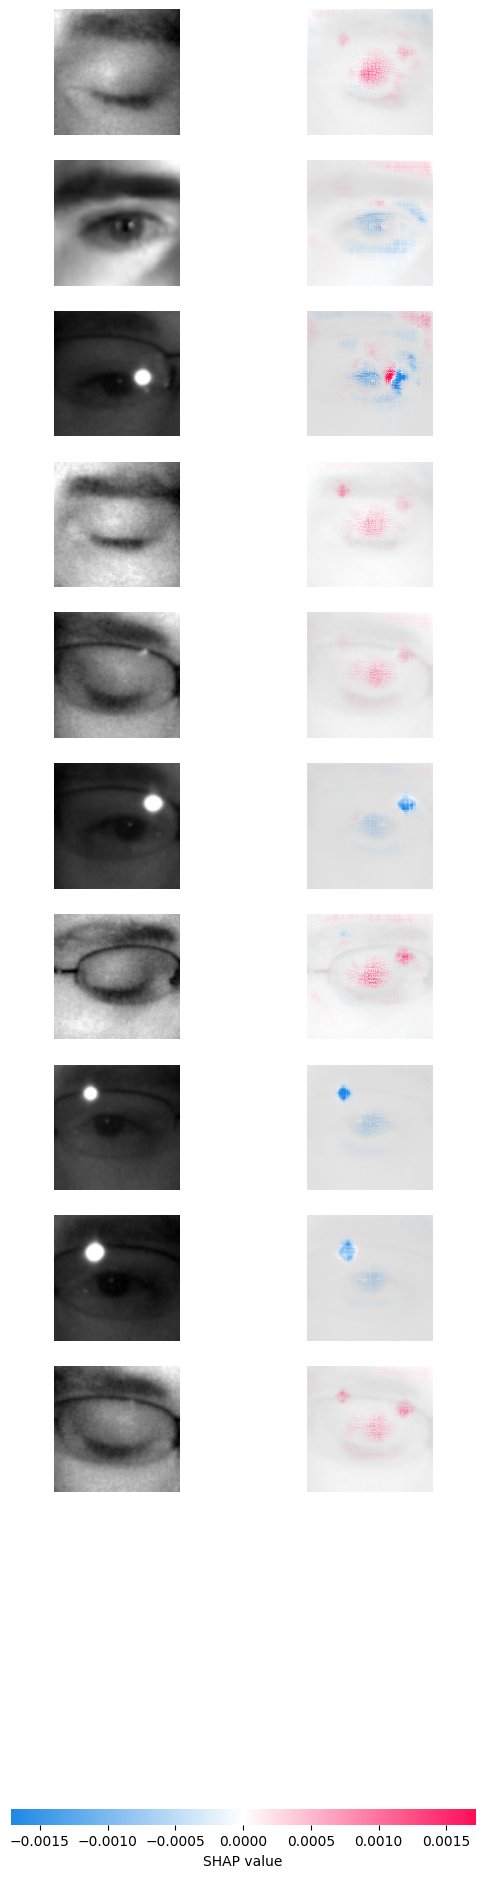

In [65]:
#shap explainer for explainable AI

background = X_eye_train[np.random.choice(X_eye_train.shape[0], 100, replace=False)]
explainer = shap.GradientExplainer(eye_model, background)

shap_values = explainer.shap_values(X_eye_test[:10])
shap.image_plot(shap_values, X_eye_test[:10])

**CNN MOUTH MODEL**

In [49]:
def load_mouth_dataset():
    X = []
    y = []

    # 0 = open, 1 = closed
    base_paths = {0: "Processed_Datasets/mouth/no_yawn",
                  1: "Processed_Datasets/mouth/yawn"}

    for label, folder in base_paths.items():
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None: #handles missing data
                continue

            img = img.astype("float32") / 255.0
            img = np.expand_dims(img, axis=-1) #Axis is 1 for grayscale

            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)

X_mouth, y_mouth = load_mouth_dataset()


In [50]:
#train test split
X_mouth_train, X_mouth_test, y_mouth_train, y_mouth_test = train_test_split(
    X_mouth, y_mouth,
    test_size=0.2, #20% test size
    stratify=y_mouth, #equal class distribution
    random_state=42 #for reproducibility
)

#model architecture for eye state classification
def build_mouth_cnn():
    model = models.Sequential([

        # Input shape: 128x128 grayscale
        layers.Input(shape=(128, 128, 1)),

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),     # Prevent overfitting
        layers.Dense(1, activation='sigmoid') #output layer
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

mouth_model = build_mouth_cnn()

history_mouth = mouth_model.fit(
    X_mouth_train, y_mouth_train,
    validation_data=(X_mouth_test, y_mouth_test),
    epochs=5,
    batch_size=32)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - accuracy: 0.6375 - loss: 0.6574 - val_accuracy: 0.8375 - val_loss: 0.4487
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.8828 - loss: 0.3185 - val_accuracy: 0.8125 - val_loss: 0.4080
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8969 - loss: 0.2643 - val_accuracy: 0.8813 - val_loss: 0.3010
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.9187 - loss: 0.2225 - val_accuracy: 0.9125 - val_loss: 0.2629
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.9328 - loss: 0.1854 - val_accuracy: 0.9062 - val_loss: 0.2528


In [18]:
#metrics for test data - mouth
y_prob_mouth = mouth_model.predict(X_mouth_test).ravel()

# Convert probability → class prediction (threshold = 0.5)
y_pred_mouth = (y_prob_mouth >= 0.5).astype(int)

acc = accuracy_score(y_mouth_test, y_pred_mouth)
rec = recall_score(y_mouth_test, y_pred_mouth, zero_division=0)
f1 = f1_score(y_mouth_test, y_pred_mouth, zero_division=0)
roc_auc = roc_auc_score(y_mouth_test, y_prob_mouth)
pr_auc = average_precision_score(y_mouth_test, y_prob_mouth)

# FNR = FN / (FN + TP)
tn, fp, fn, tp = confusion_matrix(y_mouth_test, y_pred_mouth).ravel()
fnr = fn / (fn + tp)

# print test metrics 
print("\nTest Metrics:")
print(f"Accuracy : {acc:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC-AUC  : {roc_auc:.3f}")
print(f"PR_AUC   : {pr_auc:.3f}")
print(f"FNR      : {fnr:.3f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

Test Metrics:
Accuracy : 0.956
Recall   : 0.925
F1-score : 0.955
ROC-AUC  : 0.986
PR_AUC   : 0.988
FNR      : 0.075


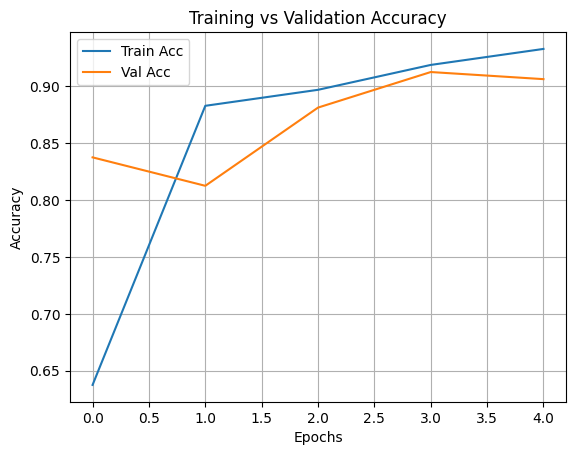

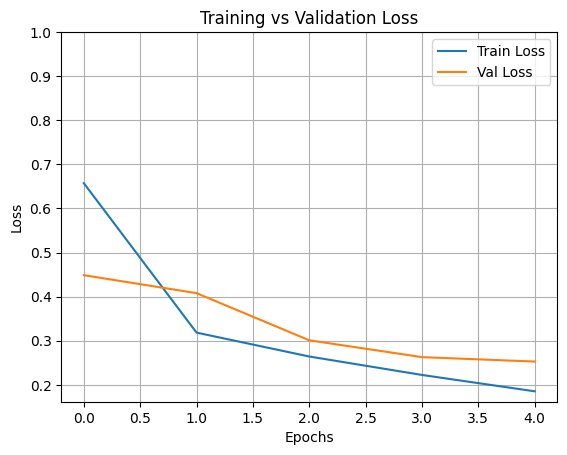

In [51]:
plt.plot(history_mouth.history["accuracy"], label="Train Acc")
plt.plot(history_mouth.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_mouth.history["loss"], label="Train Loss")
plt.plot(history_mouth.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(top=1.0)
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()


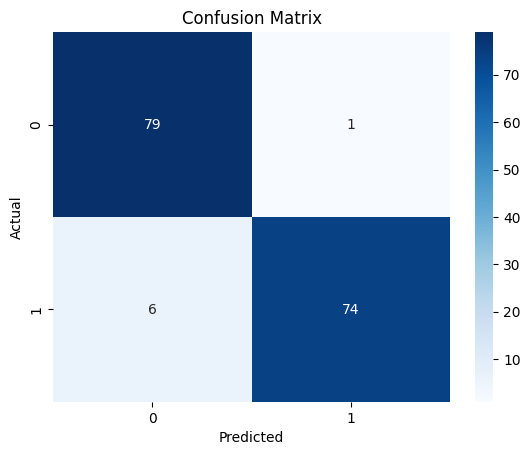

In [52]:
#confusion matrix heat map 

cm_mouth = confusion_matrix(y_mouth_test, y_pred_mouth)
sns.heatmap(cm_mouth, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Misclassified samples: 7


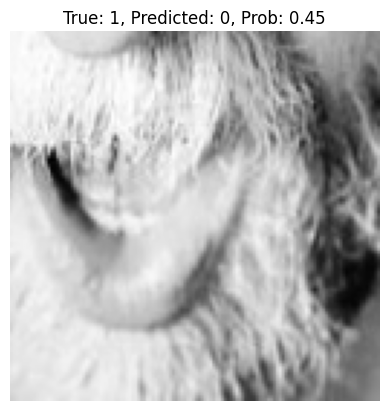

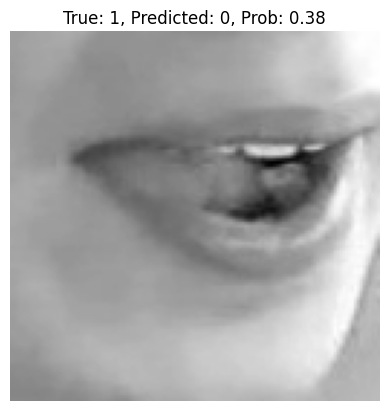

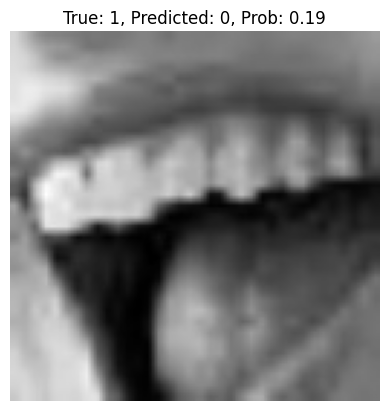

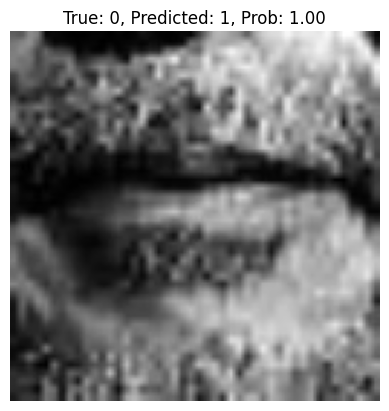

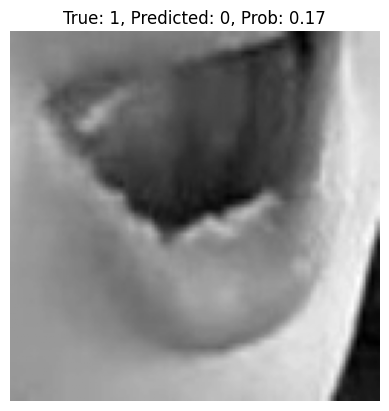

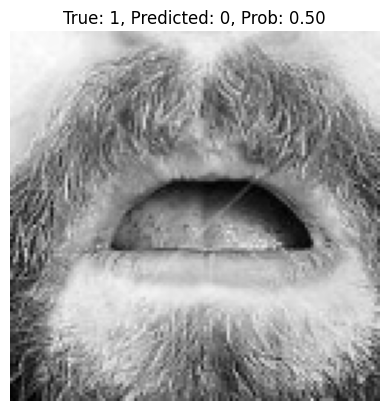

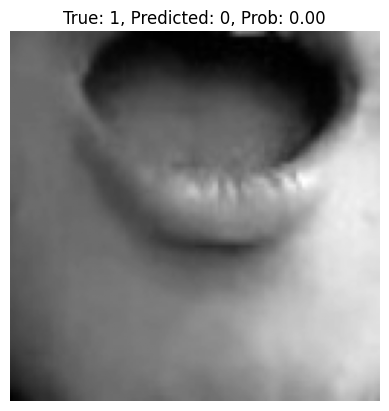

In [58]:
#dispalying mispredicted images

mis_idx = np.where(y_pred_mouth != y_mouth_test)[0]
print("Misclassified samples:", len(mis_idx))

#loop through wrongly labelled images to show all of them
for i in mis_idx:   
    plt.imshow(X_mouth_test[i].squeeze(), cmap='gray')
    plt.title(f"True: {y_mouth_test[i]}, Predicted: {y_pred_mouth[i]}, Prob: {y_prob_mouth[i]:.2f}")
    plt.axis('off')
    plt.show()

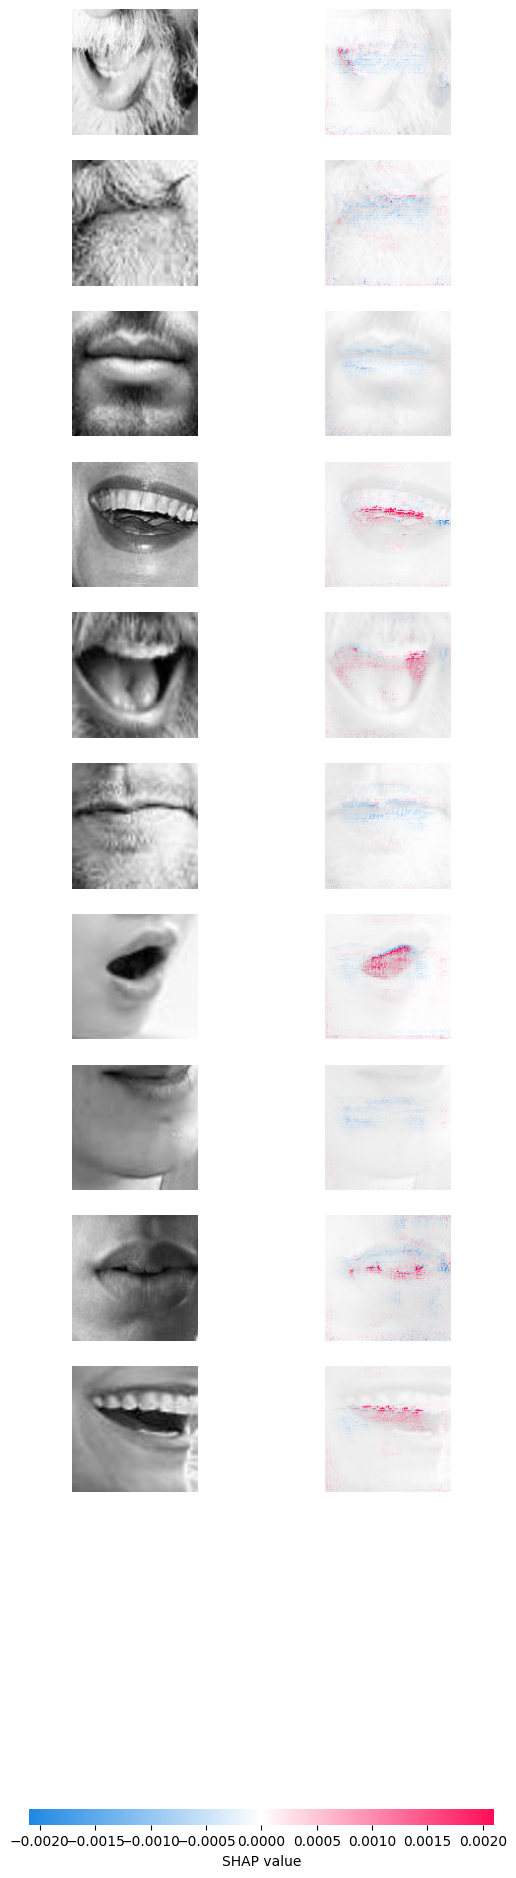

In [64]:
#shap explainer for explainable AI

background = X_mouth_train[np.random.choice(X_mouth_train.shape[0], 100, replace=False)]
explainer = shap.GradientExplainer(mouth_model, background)

shap_values = explainer.shap_values(X_mouth_test[:10])
shap.image_plot(shap_values, X_mouth_test[:10])
